# OAZ1 Coverage Analysis

[Summary](#summary)    
[OAZ1 Coverage](#oaz1-coverage)   
[A Note on the Puase Site](#a-note-on-the-pause-site)   
[Is there a Frame Shift at the Pause Site?](#frame-shift)    
[Read Lengths At the Pause Site](#read-lengths-at-pause-site)


<a name="summary"></a>
## Summary

OAZ1 has higher TE in NSP1 compared to NSP2. It also has a well-known frame shift at its pause site. So we decided to take a closer look into its coverage in the Ribosome PRofiling Data.

**Pause Site**: In all experiments, we clearly see a peak in the proximity of 68th (Ser) and 69th (Asp) amino acids. This spike is indicative of the well-known pause site of OAZ1, also reported in other studies.

**Frame Shift at the Pause Site**: Our analysis doesn't suggest any frame shift after the pause site.

**Read Length Bias at the Pause Site**: We observed that the pause site contains longer reads (>= 32 nts).



In [1]:
import ribopy
import numpy as np
import pandas as pd
import math

import scipy
import scipy.stats as stats
import matplotlib
import h5py

from collections import OrderedDict
import random
from functools import reduce

from ribopy.core.get_gadgets import get_region_boundaries
from IPython.display import display_html


In [2]:
# Widget and other plotting Functions

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

%matplotlib widget
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 6]

In [3]:
# Import the manuscript 
import sys

sys.path.append('.')
from manuscript_colors import *

In [4]:
## SYSTEM-WIDE Constants

PAUSE_START = 259
PAUSE_STOP  = 271 


LENGTH_MIN  = 28
LENGTH_MAX  = 35

FIGURE_RESOLUTION = 600

In [5]:
ribo_path = "../manuscript.ribo"

FIGURES_FOLDER = "./" 

In [6]:
def rename(x):
    return x.split("|")[4]

myribo = ribopy.Ribo(ribo_path, alias=rename)

In [7]:
NSP1_experiments = ["20200717-NSP1-HEK-1-setB",
                    "20200717-NSP1-HEK-2-setB",
                    "20200717-NSP1-HEK-3-setB"]

NSP2_experiments = ["20200717-NSP2-HEK-1-setB",
                    "20200717-NSP2-HEK-2-setB",
                    "20200717-NSP2-HEK-3-setB"]

WT_experiments = ["20200717-WT-HEK-1-setB",
                  "20200717-WT-HEK-2-setB",
                  "20200717-WT-HEK-3-setB"]

In [8]:
def get_coverage(ribo, 
                 experiment,
                 range_lower = 0,
                 range_upper = 0,
                 alias       = False,
                 multiplier  = 1000):
    """
    NOTE THAT THIS FUNCTION RETURNS A TUPLE!!!
    
    Returns a pair: (dataframe, coverage_dict)
    
    In the dataframe, the last column 
    has the coverage density of a given transcript.
    The normalized covarage is defined by
    (#total_reads / #transcript_length) * 1000000
    
    coverage_dict: This is the output of the function "get_coverage"
    of the ribo object. It contains the coverage values of each gene 
    at nucleotide resolution.

    """
    
    coverage_dict = ribo.get_coverage(experiment  = experiment,
                                      range_lower = range_lower, 
                                      range_upper = range_upper,
                                      alias       = alias)
    
    region_boundaries = get_region_boundaries(ribo._handle)
    
    transcript_names     = coverage_dict.keys()
    transcript_coverages = coverage_dict.values()
    transcript_total     = tuple( map( np.sum, transcript_coverages ) )
    transcript_lengths   = tuple( map(len, transcript_coverages) )
    normalized_coverage  = np.divide(transcript_total , transcript_lengths) * multiplier
    start_sites          = tuple( map( lambda x: x[1][0], region_boundaries ) )
    stop_sites           = tuple( map( lambda x: x[1][1], region_boundaries ) )
    
    # We also add normalized cds coverage
    cds_data = zip( start_sites, stop_sites, transcript_coverages )
    norm_cds = tuple( map( lambda x:  
                              (np.sum( x[2][x[0]:x[1]] ) / (x[1] - x[0]) )* multiplier,
                      cds_data) )
    
    result = pd.DataFrame(data = { "total"     :  transcript_total, 
                                   "length"    :  transcript_lengths,
                                   "cds_start" :  start_sites,
                                   "cds_stop"  :  stop_sites,
                                   "norm_cds"  :  norm_cds,
                                   "norm_cov"  :  normalized_coverage}, 
                          index = transcript_names) 
    
    return( (result, coverage_dict))


coverages = { e: get_coverage(
                     ribo        = myribo, 
                     experiment  = e,
                     range_lower = LENGTH_MIN,
                     range_upper = LENGTH_MAX,
                     alias       = rename)\
                 for e in NSP1_experiments + NSP2_experiments + WT_experiments }

In [9]:
def bin_vector( vector, bin_size ):
    """
    Given an array, it splits the array into bins of size "bin_size"
    then sums the values in each bin
    """
    v_len     = len(vector)
    remainder = v_len % bin_size
    numb_bins = (v_len - remainder) // bin_size
    
    result = [ np.sum( vector[i*bin_size:(i+1)*bin_size] ) for i in range(numb_bins) ]
    
    if remainder > 0:
        result.append( np.sum( vector[ (numb_bins)*bin_size : v_len] ) )
        
    return( result )


In [10]:

# Get depth for each experiment
# ofor normalization purposes
depth_dict = { e: myribo.info["experiments"][e]["Reads"] for e in myribo.experiments}

<a name="oaz1-coverage"></a>
## OAZ1 Coverage


In [11]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [16, 16]

display_html("<center><b>OAZ1 Coverage Across Different Conditions</b></center>", raw = True)
display_html("<center>Pause site is highlighted in red</center>", raw = True)

this_gene = "OAZ1-211"

cds_start   = coverages[NSP1_experiments[0]][0].loc[this_gene, "cds_start"]
cds_stop    = coverages[NSP1_experiments[0]][0].loc[this_gene, "cds_stop"]

xrange          = tuple(range(cds_start, cds_stop))

experiments = ["20200717-NSP1-HEK-1-setB", 
               "20200717-NSP2-HEK-1-setB", 
               "20200717-WT-HEK-1-setB"]

titles = ["NSP1-1", "NSP2-1", "WT-1"]
coverage_colors = [EXPERIMENT_COLORS["20200717-NSP1-HEK-1-setB"], 
                   EXPERIMENT_COLORS["20200717-NSP2-HEK-1-setB"],
                   EXPERIMENT_COLORS["20200717-WT-HEK-1-setB"]]

plt.figure( 1, (16,16),dpi = FIGURE_RESOLUTION )
for i in range(3):
    e = experiments[i]
    
    plt.subplot(3,1,1 + i)
    plt.ylim(bottom = -0.3 , top = 17.5)
    plt.plot(xrange, coverages[e][1][this_gene][cds_start: cds_stop], 
             color = coverage_colors[i])
    #plt.axvspan(cds_start , cds_stop, color='gray', alpha=0.1)
    plt.fill_between(x     = (PAUSE_START , PAUSE_STOP), 
                     y1    = -0.3, y2 = 0, 
                     color = "#e31a1d", alpha = 0.8)
    #plt.axvspan(pause_start , pause_stop, color='red', alpha=0.2);
    plt.ylabel("Number of Mapped Reads")
    plt.xlabel("Nucleotide Position")
    plt.title(titles[i]);
    
plt.savefig("OAZ1_cds_coverage.pdf")

OAZ1 Coverage Across Different Conditions

Pause site is highlighted in red

**Figure:**
Coverage plots of the coding sequence of OAZ1 for the first replicates of each condition; NSP1, NSP2 and Wild Type. The pause site, spanning the positions from 259 to 271, is marked in red. The five prime ends of the ribosome footprints are taken for the coverage profile. The x-axis shows the nucleotide positions and the y-axis shows the number of mapped reads.

In [12]:
OAZ1_seq = \
"""
ATTTTGCGAACGGCGAGCAGCGGCGGCGGCGCGGAGAGACGCAGCGGAGG
TTTTCCTGGTTTCGGACCCCAGCGGCCGGATGGTGAAATCCTCCCTGCAG
CGGATCCTCAATAGCCACTGCTTCGCCAGAGAGAAGGAAGGGGATAAACC
CAGCGCCACCATCCACGCCAGCCGCACCATGCCGCTCCTAAGCCTGCACA
GCCGCGGCGGCAGCAGCAGTGAGAGTTCCAGGGTCTCCCTCCACTGCTGT
AGTAACCCGGGTCCGGGGCCTCGGTGGTGCTCCGATGCCCCTCACCCACC
CCTGAAGATCCCAGGTGGGCGAGGGAATAGTCAGAGGGATCACAATCTTT
CAGCTAACTTATTCTACTCCGATGATCGGCTGAATGTAACAGAGGAACTA
ACGTCCAACGACAAGACGAGGATTCTCAACGTCCAGTCCAGGCTCACAGA
CGCCAAACGCATTAACTGGCGAACAGTGCTGAGTGGCGGCAGCCTCTACA
TCGAGATCCCGGGCGGCGCGCTGCCCGAGGGGAGCAAGGACAGCTTTGCA
GTTCTCCTGGAGTTCGCTGAGGAGCAGCTGCGAGCCGACCATGTCTTCAT
TTGCTTCCACAAGAACCGCGAGGACAGAGCCGCCTTGCTCCGAACCTTCA
GCTTTTTGGGCTTTGAGATTGTGAGACCGGGGCATCCCCTTGTCCCCAAG
AGACCCGACGCTTGCTTCATGGCCTACACGTTCGAGAGAGAGTCTTCGGG
AGAGGAGGAGGAGTAGGGCCGCCTCGGGGCTGGGCATCCGGCCCCTGGGG
CCACCCCTTGTCAGCCGGGTGGGTAGGAACCGTAGACTCGCTCATCTCGC
CTGGGTTTGTCCGCATGTTGTAATCGTGCAAATAAACGCTCACTCCGAAT
TAGCGGTGTATTTCTTGAAGTTTAATATTGTGTTTGTGATACTGAAGTAT
TTGCTTTAATTCTAAATAAAAATTTATATTTTACTTTTTTATTGCTGGTT
TAAGATGATTCAGATTATCCTTGTACTTTGAGGAGAAGTTTCTTATTTGG
AGTCTTTTGGAAACAGTCTTAGTCTTTTAACTTGGAAAGATGAGGTATTA
ATCCCCTCCATTGCTCTCCAAAAGCCAATAAAGTGATTACACCCGATG
"""

OAZ1_seq = OAZ1_seq.replace("\n", "")

<a name="a-note-on-the-pause-site"></a>
## A note on the Pause Site


It has been reported that OAZ has a puase site around the amino acids 68-Ser and 69-Asp.
This is consistenmt with our findings.
First, in our transcript refrence, we see Ser and Asp at the expected positions.

**68-Ser:** TCT TCC TCA TCG AGT AGC

**69-Asp:** GAT GAC

In [13]:
OAZ1_seq[280:286]

'TCCGAT'

In [14]:
# The start site is at the nucleotide position 79
OAZ1_seq[79:82]

'ATG'

Ser *starts* at position 280 so it is the ((280-79) / 3 ) + 1 = $68^{th}$ nucleotide. 

Also note that the  peak spans the positions 260 to 270, centered at 265. First, we mapped the 5' end of the reads. Second, this peak is coming from mostly larger fragments (RNA fragments of length 32, 33,34,35). These together show that the peak (pause site) come from the region 68-Ser and 69-Asp.

--------------------------------------------------------------------------------

<a name="frame-shift"></a>
## Frame Shift at the Pause Site 

In this section we try to answer the following two questions.

**Question 1:** Do we observe a frame shift after the pause site?

**Question 2:** If the answer to the previous question is 'yes', then do we see a difference in between the groups NSP1, NSP2 and WT?

To answer these questions, we consider the coverages for each individual read length.

In [15]:
read_length_range = tuple(range(28, 36))

EXPERIMENT_SET = NSP1_experiments + NSP2_experiments + WT_experiments

all_coverages = dict()

for i in read_length_range:
    all_coverages[i] = dict()
    for e in EXPERIMENT_SET:
        all_coverages[i][e] = myribo.get_coverage(
                                      experiment  = e,
                                      range_lower = i, 
                                      range_upper = i,
                                      alias       = rename)

In [16]:
# First, we read the coverages of OAZ1 for each read length




# Sample coverage access
# OAZ1_coverages[length][experiment]
# returns the coverage array for the entire transcript
OAZ1_coverages = dict()


for i in read_length_range:
    OAZ1_coverages[i] = dict()
    for e in EXPERIMENT_SET:
        OAZ1_coverages[i][e] = all_coverages[i][e]["OAZ1-211"]

In what follows, we find the distribution of the counts at EPA sites to the left and right of the pause site.
We indicate these counts as 'triplets' and refer to these sites by their indices names 0, 1, 2.

In [17]:
def find_triplet_frequency(v):
    """
    It moves on the given array 3 nucleotides at each step.
    It returnms the sum of all values at positions 0,1 and 2
    in these triplets. See example bedow
    """
    triplet_histogram = [0,0,0]
    
    for i, val in enumerate(v):
        triplet_index                     = i % 3
        triplet_histogram[triplet_index] += val
        
    return triplet_histogram

assert find_triplet_frequency((1,2,3,5,10,7)) == [6,12, 10]

#  1   2   3
#  +   +   +
#  5  10   7
##############
#  6  12  10
# 

In [18]:


def display_side_by_side(*args):
    """
    Displays Pandas DataFrames side-by-side
    """
    html_str = ''
    for df in args:
        html_str += df.to_html()
        
    display_html(html_str.replace('table','table style="display:inline"'), raw = True)

In [19]:
left_distributions = dict()
right_distributions = dict()

for i in read_length_range:
    left_distributions[i] = dict()
    right_distributions[i] = dict()
    
    for e in EXPERIMENT_SET:
        left_distributions[i][e] = find_triplet_frequency( 
                                     OAZ1_coverages[i][e][79:PAUSE_START] )
        right_distributions[i][e] = find_triplet_frequency( 
                                     OAZ1_coverages[i][e][PAUSE_STOP:762] )
        

In [20]:
def make_df_of_exp_dist(dist_dict, experiment):
    df_dict = { "length" : read_length_range}
    for z in range(3):
            df_dict[z] = [ dist_dict[this_length][experiment][z] \
                              for this_length in read_length_range ]
    return pd.DataFrame(df_dict)

left_right_dist = dict()

for e in EXPERIMENT_SET:
    left_right_dist[e + "_left"]  = make_df_of_exp_dist(dist_dict = left_distributions,  experiment = e)
    left_right_dist[e + "_right"] = make_df_of_exp_dist(dist_dict = right_distributions,  experiment = e)


The following tables show the coverage of two regions of the CDS of the gene OAZ1.

The left of the puase site spanning [79:259) is called **left** and shown for each 3 replicates.  
The right of the pause site spanning [271:762) is called **right** and shown for each 3 replicates.  
The top row is coming from the NSP1 replicates and the bottom row is coming from WT replicates


In [21]:
display_html("<center><b>Counts</b></center>", raw = True)
display_html("<center>NSP1 OAZ1 pause site (3 Left + 3 Right)</center>", raw = True)
display_side_by_side(*([ left_right_dist[e + "_left"] for e in NSP1_experiments ] + \
                       [ left_right_dist[e + "_right"] for e in NSP1_experiments ] ))

display_html("<center>WT OAZ1 pause site (3 Left + 3 Right)</center>", raw = True)
display_side_by_side(*([ left_right_dist[e + "_left"] for e in  WT_experiments ] + \
                       [ left_right_dist[e + "_right"] for e in WT_experiments ] ))

Counts

NSP1 OAZ1 pause site (3 Left + 3 Right)

length 
 0 
 1 
 2 
 
 
 
 
 0 
 28 
 0 
 0 
 0 
 
 
 1 
 29 
 1 
 0 
 0 
 
 
 2 
 30 
 2 
 1 
 2 
 
 
 3 
 31 
 2 
 0 
 1 
 
 
 4 
 32 
 1 
 0 
 2 
 
 
 5 
 33 
 2 
 0 
 1 
 
 
 6 
 34 
 1 
 0 
 1 
 
 
 7 
 35 
 0 
 0 
 0 
 
 
 
 
 
 
 length 
 0 
 1 
 2 
 
 
 
 
 0 
 28 
 1 
 1 
 2 
 
 
 1 
 29 
 0 
 1 
 0 
 
 
 2 
 30 
 1 
 0 
 0 
 
 
 3 
 31 
 1 
 0 
 0 
 
 
 4 
 32 
 0 
 0 
 2 
 
 
 5 
 33 
 2 
 1 
 0 
 
 
 6 
 34 
 0 
 1 
 2 
 
 
 7 
 35 
 3 
 0 
 0 
 
 
 
 
 
 
 length 
 0 
 1 
 2 
 
 
 
 
 0 
 28 
 1 
 2 
 0 
 
 
 1 
 29 
 1 
 3 
 0 
 
 
 2 
 30 
 1 
 1 
 3 
 
 
 3 
 31 
 3 
 1 
 4 
 
 
 4 
 32 
 4 
 1 
 2 
 
 
 5 
 33 
 0 
 0 
 2 
 
 
 6 
 34 
 3 
 2 
 2 
 
 
 7 
 35 
 3 
 3 
 0 
 
 
 
 
 
 
 length 
 0 
 1 
 2 
 
 
 
 
 0 
 28 
 11 
 7 
 22 
 
 
 1 
 29 
 14 
 7 
 11 
 
 
 2 
 30 
 27 
 9 
 5 
 
 
 3 
 31 
 26 
 11 
 27 
 
 
 4 
 32 
 9 
 14 
 29 
 
 
 5 
 33 
 18 
 10 
 16 
 
 
 6 
 34 
 3 
 4 
 24 
 
 
 7 
 35 
 1 
 2 
 10 
 
 
 
 
 
 
 length 
 0 
 1 
 2 
 
 
 
 
 0 
 28 
 8 
 3 
 14 
 
 
 1 
 29 
 16 
 14 
 8 
 
 
 2 
 30 
 19 
 8 
 17 
 
 
 3 
 31 
 14 
 4 
 22 
 
 
 4 
 32 
 9 
 5 
 15 
 
 
 5 
 33 
 11 
 6 
 17 
 
 
 6 
 34 
 7 
 3 
 9 
 
 
 7 
 35 
 3 
 8 
 5 
 
 
 
 
 
 
 length 
 0 
 1 
 2 
 
 
 
 
 0 
 28 
 15 
 8 
 19 
 
 
 1 
 29 
 9 
 14 
 12 
 
 
 2 
 30 
 40 
 11 
 15 
 
 
 3 
 31 
 20 
 10 
 43 
 
 
 4 
 32 
 17 
 10 
 33 
 
 
 5 
 33 
 22 
 11 
 21 
 
 
 6 
 34 
 7 
 7 
 35 
 
 
 7 
 35 
 14 
 4 
 16

WT OAZ1 pause site (3 Left + 3 Right)

length 
 0 
 1 
 2 
 
 
 
 
 0 
 28 
 1 
 0 
 1 
 
 
 1 
 29 
 0 
 0 
 0 
 
 
 2 
 30 
 1 
 0 
 0 
 
 
 3 
 31 
 3 
 1 
 4 
 
 
 4 
 32 
 2 
 0 
 3 
 
 
 5 
 33 
 1 
 0 
 3 
 
 
 6 
 34 
 0 
 0 
 0 
 
 
 7 
 35 
 1 
 0 
 0 
 
 
 
 
 
 
 length 
 0 
 1 
 2 
 
 
 
 
 0 
 28 
 0 
 0 
 2 
 
 
 1 
 29 
 2 
 0 
 1 
 
 
 2 
 30 
 2 
 2 
 0 
 
 
 3 
 31 
 0 
 1 
 2 
 
 
 4 
 32 
 0 
 1 
 5 
 
 
 5 
 33 
 8 
 2 
 7 
 
 
 6 
 34 
 3 
 2 
 1 
 
 
 7 
 35 
 1 
 3 
 1 
 
 
 
 
 
 
 length 
 0 
 1 
 2 
 
 
 
 
 0 
 28 
 3 
 0 
 1 
 
 
 1 
 29 
 0 
 2 
 2 
 
 
 2 
 30 
 1 
 0 
 2 
 
 
 3 
 31 
 5 
 0 
 2 
 
 
 4 
 32 
 1 
 3 
 5 
 
 
 5 
 33 
 4 
 0 
 1 
 
 
 6 
 34 
 0 
 1 
 3 
 
 
 7 
 35 
 0 
 2 
 2 
 
 
 
 
 
 
 length 
 0 
 1 
 2 
 
 
 
 
 0 
 28 
 10 
 1 
 8 
 
 
 1 
 29 
 11 
 6 
 9 
 
 
 2 
 30 
 17 
 9 
 12 
 
 
 3 
 31 
 10 
 5 
 23 
 
 
 4 
 32 
 12 
 6 
 16 
 
 
 5 
 33 
 17 
 5 
 20 
 
 
 6 
 34 
 5 
 4 
 18 
 
 
 7 
 35 
 3 
 3 
 6 
 
 
 
 
 
 
 length 
 0 
 1 
 2 
 
 
 
 
 0 
 28 
 13 
 8 
 25 
 
 
 1 
 29 
 15 
 9 
 26 
 
 
 2 
 30 
 25 
 14 
 21 
 
 
 3 
 31 
 20 
 12 
 39 
 
 
 4 
 32 
 21 
 15 
 30 
 
 
 5 
 33 
 19 
 14 
 38 
 
 
 6 
 34 
 18 
 6 
 33 
 
 
 7 
 35 
 10 
 5 
 17 
 
 
 
 
 
 
 length 
 0 
 1 
 2 
 
 
 
 
 0 
 28 
 4 
 5 
 20 
 
 
 1 
 29 
 6 
 14 
 8 
 
 
 2 
 30 
 24 
 11 
 7 
 
 
 3 
 31 
 15 
 5 
 39 
 
 
 4 
 32 
 11 
 7 
 25 
 
 
 5 
 33 
 22 
 8 
 26 
 
 
 6 
 34 
 9 
 10 
 20 
 
 
 7 
 35 
 7 
 4 
 13

The left side of the puase site has very few peaks so we decide to aggregate the frame counts. From the counts on the right side, we see that the frame at position two (rightmost frame position) has the dominant frame. By dominant frame, we mean the frame having the most number of reads.

So we decided to aggregate the reads from length 31 to 35 and determine their percentages.

In [22]:
def find_triplet_perc(triplet_df):
    sums        =  triplet_df.loc[ triplet_df.length >= 31 ].iloc[:, 1:4].sum()
    percentages = np.multiply(np.divide( sums, np.sum(sums) ) , 100)
    return percentages


In [23]:
display_html("<center><b>Percentages</b></center>", raw = True)
display_html("<center>NSP1 OAZ1 pause site (3 Left + 3 Right)</center>", raw = True)
display_side_by_side(*([pd.DataFrame(find_triplet_perc(left_right_dist[e + "_left"]), columns = [e[9:]]) \
                       for e in NSP1_experiments] +\
                       [pd.DataFrame(find_triplet_perc(left_right_dist[e + "_right"]), columns = [e[9:]]) \
                       for e in NSP1_experiments]))
display_html("<center>WT OAZ1 pause site (3 Left + 3 Right)</center>", raw = True)
display_side_by_side(*([pd.DataFrame(find_triplet_perc(left_right_dist[e + "_left"]), columns = [e[9:]]) \
                       for e in WT_experiments] +\
                       [pd.DataFrame(find_triplet_perc(left_right_dist[e + "_right"]), columns = [e[9:]]) \
                       for e in WT_experiments]))

Percentages

NSP1 OAZ1 pause site (3 Left + 3 Right)

NSP1-HEK-1-setB 
 
 
 
 
 0 
 54.545455 
 
 
 1 
 0.000000 
 
 
 2 
 45.454545 
 
 
 
 
 
 
 NSP1-HEK-2-setB 
 
 
 
 
 0 
 50.000000 
 
 
 1 
 16.666667 
 
 
 2 
 33.333333 
 
 
 
 
 
 
 NSP1-HEK-3-setB 
 
 
 
 
 0 
 43.333333 
 
 
 1 
 23.333333 
 
 
 2 
 33.333333 
 
 
 
 
 
 
 NSP1-HEK-1-setB 
 
 
 
 
 0 
 27.941176 
 
 
 1 
 20.098039 
 
 
 2 
 51.960784 
 
 
 
 
 
 
 NSP1-HEK-2-setB 
 
 
 
 
 0 
 31.884058 
 
 
 1 
 18.840580 
 
 
 2 
 49.275362 
 
 
 
 
 
 
 NSP1-HEK-3-setB 
 
 
 
 
 0 
 29.629630 
 
 
 1 
 15.555556 
 
 
 2 
 54.814815

WT OAZ1 pause site (3 Left + 3 Right)

WT-HEK-1-setB 
 
 
 
 
 0 
 38.888889 
 
 
 1 
 5.555556 
 
 
 2 
 55.555556 
 
 
 
 
 
 
 WT-HEK-2-setB 
 
 
 
 
 0 
 32.432432 
 
 
 1 
 24.324324 
 
 
 2 
 43.243243 
 
 
 
 
 
 
 WT-HEK-3-setB 
 
 
 
 
 0 
 34.482759 
 
 
 1 
 20.689655 
 
 
 2 
 44.827586 
 
 
 
 
 
 
 WT-HEK-1-setB 
 
 
 
 
 0 
 30.718954 
 
 
 1 
 15.032680 
 
 
 2 
 54.248366 
 
 
 
 
 
 
 WT-HEK-2-setB 
 
 
 
 
 0 
 29.629630 
 
 
 1 
 17.508418 
 
 
 2 
 52.861953 
 
 
 
 
 
 
 WT-HEK-3-setB 
 
 
 
 
 0 
 28.959276 
 
 
 1 
 15.384615 
 
 
 2 
 55.656109

Though the distributions to the left and right of the pause sites are significantly different,
this is due to low coverage at the left of the pause site. This can be seen from the tables above. Also notice the high variance in the test statistics across different experiments.

IF we took the statistical significance at its face value, we would conclude that ribosome is **out of frame on the left of the pause site**. However, it is know that the ribosome shifts frame and becomes out of frame after (to the right of ) the pause site. 

In [24]:

for e in EXPERIMENT_SET:
    print( stats.chisquare( find_triplet_perc(left_right_dist[e + "_left"]), 
                 find_triplet_perc(left_right_dist[e + "_right"]))   )

Power_divergenceResult(statistic=46.244060173824536, pvalue=9.083012729853016e-11)
Power_divergenceResult(statistic=15.701700260523802, pvalue=0.00038942076911106116)
Power_divergenceResult(statistic=18.64527027027028, pvalue=8.93780765026613e-05)
Power_divergenceResult(statistic=80.3461634650321, pvalue=3.573158510140633e-18)
Power_divergenceResult(statistic=40.95491375334821, pvalue=1.2786552762514487e-09)
Power_divergenceResult(statistic=35.0967244108837, pvalue=2.392451418784303e-08)
Power_divergenceResult(statistic=8.179062224847588, pvalue=0.01674708421762587)
Power_divergenceResult(statistic=4.668726819699453, pvalue=0.0968721307463227)
Power_divergenceResult(statistic=4.989644055180147, pvalue=0.08251113479059076)


In [25]:
left_percentage_vectors  = dict()
right_percentage_vectors = dict()

for i in range(3):
    left_percentage_vectors[i] = \
        [ find_triplet_perc(left_right_dist[e + "_left"])[i] for e in EXPERIMENT_SET ]
    right_percentage_vectors[i] = \
        [ find_triplet_perc(left_right_dist[e + "_right"])[i] for e in EXPERIMENT_SET ]

    

Triplet percentages for read lengths 31,...,35 aggregated

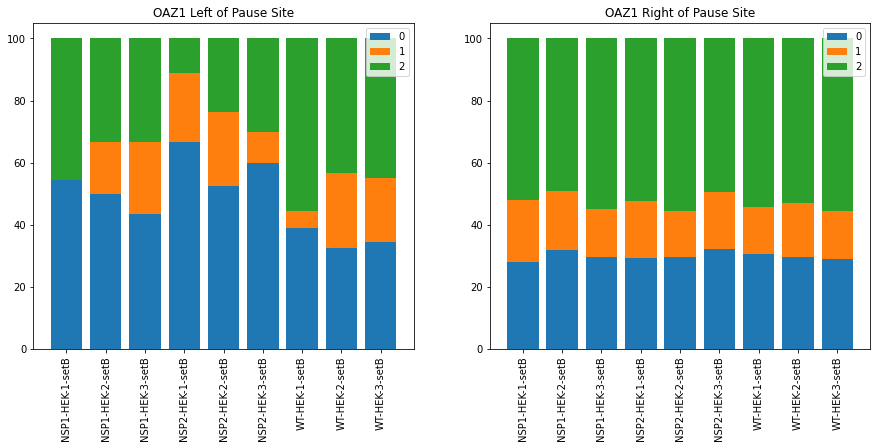

In [26]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 6]
display_html("<center><b>Triplet percentages for read lengths 31,...,35 aggregated</b></center>", raw = True)
ind = range(len(left_percentage_vectors[0]))

plt.subplot(1,2,1)

plt.bar(ind, left_percentage_vectors[0])
plt.bar(ind, left_percentage_vectors[1], bottom = left_percentage_vectors[0])
plt.bar(ind, left_percentage_vectors[2], bottom = np.add(left_percentage_vectors[0] , left_percentage_vectors[1]) )

plt.legend((0,1,2))
plt.xticks( ind, map(lambda x: x[9:], EXPERIMENT_SET) , rotation=90 );
plt.title("OAZ1 Left of Pause Site")

plt.subplot(1,2,2)

plt.title("OAZ1 Right of Pause Site")
plt.bar(ind, right_percentage_vectors[0])
plt.bar(ind, right_percentage_vectors[1], bottom = right_percentage_vectors[0])
plt.bar(ind, right_percentage_vectors[2], bottom = np.add(right_percentage_vectors[0] , right_percentage_vectors[1]) )

plt.legend((0,1,2))
plt.xticks( ind, map(lambda x: x[9:], EXPERIMENT_SET) , rotation=90 );

**Note**: This figure will not be included in the publication.

In [27]:
EEF1A1_triplets = dict()
EEF1A1_start    = int(coverages["20200717-NSP1-HEK-1-setB"][0].loc["EEF1A1-202"].cds_start)
EEF1A1_stop     = int(coverages["20200717-NSP1-HEK-1-setB"][0].loc["EEF1A1-202"].cds_stop)

HIST1H4C_triplets = dict()
HIST1H4C_start    = int(coverages["20200717-NSP1-HEK-1-setB"][0].loc["HIST1H4C-201"].cds_start)
HIST1H4C_stop     = int(coverages["20200717-NSP1-HEK-1-setB"][0].loc["HIST1H4C-201"].cds_stop)

DHX15_triplets = dict()
DHX15_start    = int(coverages["20200717-NSP1-HEK-1-setB"][0].loc["DHX15-201"].cds_start)
DHX15_stop     = int(coverages["20200717-NSP1-HEK-1-setB"][0].loc["DHX15-201"].cds_stop)

# HIST1H4C-201
# DHX15-201
# RPS18-230

for i in read_length_range:
    EEF1A1_triplets[i]   = dict()
    HIST1H4C_triplets[i] = dict()
    DHX15_triplets[i]    = dict()

    
    for e in EXPERIMENT_SET:
        EEF1A1_triplets[i][e]   = find_triplet_frequency( 
                                     all_coverages[i][e]["EEF1A1-202"][EEF1A1_start:EEF1A1_stop] )
        HIST1H4C_triplets[i][e] = find_triplet_frequency( 
                                     all_coverages[i][e]["HIST1H4C-201"][HIST1H4C_start:HIST1H4C_stop] )
        DHX15_triplets[i][e]    = find_triplet_frequency( 
                                     all_coverages[i][e]["DHX15-201"][DHX15_start:DHX15_stop] )


EEF1A1_percentage_vectors   = dict()
HIST1H4C_percentage_vectors = dict()
DHX15_percentage_vectors    = dict()

for i in range(3):
    EEF1A1_percentage_vectors[i] = \
        [ find_triplet_perc(make_df_of_exp_dist(dist_dict = EEF1A1_triplets, experiment = e))[i] for e in EXPERIMENT_SET ]
    HIST1H4C_percentage_vectors[i] = \
        [ find_triplet_perc(make_df_of_exp_dist(dist_dict = HIST1H4C_triplets, experiment = e))[i] for e in EXPERIMENT_SET ]
    DHX15_percentage_vectors[i] = \
        [ find_triplet_perc(make_df_of_exp_dist(dist_dict = DHX15_triplets, experiment = e))[i] for e in EXPERIMENT_SET ]
    
    

    
    

In [28]:
EEF1A1_percentage_vectors[0]

[35.61884967763827,
 37.33671493632224,
 33.27150512064428,
 34.45427344867959,
 33.49952409010561,
 34.338574884539256,
 33.904428904428904,
 31.407384115504545,
 30.81359240528791]

In [29]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [16, 16]
plt.figure( 1, (16,16),dpi = FIGURE_RESOLUTION );

display_html("<center><b>Triplet percentages for read lengths 31,...,35 aggregated</b></center>", raw = True)

label_ind = (2,6,10)
xlabels   = ("NSP1", "NSP2", "WT")
ind       = (1,2,3,5,6,7,9,10,11)
WIDTH     = 0.85 
ytics     = (0,25,50,75,100)

plt.subplot(2,2,1)

plt.ylabel("Percentage")

#ax.bar(ind, EEF1A1_percentage_vectors[0], width = 0.5, color = "blue" )
plt.bar(ind, EEF1A1_percentage_vectors[0],color = FRAME_COLORS[0], 
        width = WIDTH)

plt.bar(ind, EEF1A1_percentage_vectors[1], 
        bottom = EEF1A1_percentage_vectors[0],
        color  = FRAME_COLORS[1],
        width  = WIDTH)

plt.bar(ind, EEF1A1_percentage_vectors[2], 
        bottom = np.add(EEF1A1_percentage_vectors[0] , EEF1A1_percentage_vectors[1]),
        color  = FRAME_COLORS[2],
        width  = WIDTH)

plt.tight_layout(pad=3);
plt.xticks( label_ind, xlabels , rotation=0 );
plt.yticks(ytics, tuple(map(str ,ytics))  );
plt.title("EEF1A1");


########################################################################################
plt.subplot(2,2,2)

plt.title("OAZ1")
plt.bar(ind, right_percentage_vectors[0],
        color = FRAME_COLORS[0], 
        width = WIDTH)

plt.bar(ind, right_percentage_vectors[1], 
        bottom = right_percentage_vectors[0],
        color  = FRAME_COLORS[1], 
        width  = WIDTH)

plt.bar(ind, right_percentage_vectors[2], 
        bottom = np.add(right_percentage_vectors[0] , right_percentage_vectors[1]),
        color  = FRAME_COLORS[2], 
        width  = WIDTH)

plt.legend((0,1,2), 
           loc= "upper right",
           bbox_to_anchor=(1.15, 1))
plt.xticks( label_ind, xlabels , rotation=0 );
plt.yticks(ytics, tuple(map(str ,ytics))  );
plt.tight_layout(pad=3);

##################################################################################################
plt.subplot(2,2,3)

plt.ylabel("Percentage")
plt.bar(ind, HIST1H4C_percentage_vectors[0],
        color = FRAME_COLORS[0], 
        width = WIDTH)

plt.bar(ind, HIST1H4C_percentage_vectors[1], 
        bottom = HIST1H4C_percentage_vectors[0],
        color = FRAME_COLORS[1], 
        width = WIDTH)

plt.bar(ind, HIST1H4C_percentage_vectors[2], 
        bottom = np.add(HIST1H4C_percentage_vectors[0] , HIST1H4C_percentage_vectors[1]), 
        color  = FRAME_COLORS[2], 
        width  = WIDTH)

plt.xticks( label_ind, xlabels , rotation=0 );
plt.yticks(ytics, tuple(map(str ,ytics))  );
plt.tight_layout(pad=3);
plt.title("HIST1H4C");

################################################################################################
plt.subplot(2,2,4)

plt.bar(ind, DHX15_percentage_vectors[0],
        color = FRAME_COLORS[0], 
        width = WIDTH)

plt.bar(ind, DHX15_percentage_vectors[1], 
        bottom = DHX15_percentage_vectors[0],
        color  = FRAME_COLORS[1], 
        width  = WIDTH)

plt.bar(ind, DHX15_percentage_vectors[2], 
        bottom = np.add(DHX15_percentage_vectors[0] , DHX15_percentage_vectors[1]),
        color  = FRAME_COLORS[2], 
        width  = WIDTH)


plt.xticks( label_ind, xlabels , rotation=0 );

plt.yticks(ytics, tuple(map(str ,ytics))  );

plt.tight_layout(pad=2);
plt.title("DHX15");

plt.savefig("frame_percentages.pdf");

Triplet percentages for read lengths 31,...,35 aggregated

**Figure**: Comparison of the distribution of the reads at each frame position. We took the footprints with lengths between 31 to 35 (both inclusive) nucleotides. For the genes EEF1A1, HIST1H4C and DHX15, we aggregated the reads in the frame positions 0,1 and 2 in the entire coding region. For OAZ1, we aggregated the reads to the right of the pause site (nucleotide positions from 271 to 763). We depict the percentages of the frame positions for each repliacte. 

In [30]:
cds_stop

763

In [31]:
EEF1A1_NSP1_1_percentages   = find_triplet_perc(make_df_of_exp_dist(dist_dict = EEF1A1_triplets, experiment = "20200717-NSP1-HEK-1-setB"))
EEF1A1_WT_1_percentages     = find_triplet_perc(make_df_of_exp_dist(dist_dict = EEF1A1_triplets, experiment = "20200717-WT-HEK-1-setB"))

HIST1H4C_NSP1_2_percentages = find_triplet_perc(make_df_of_exp_dist(dist_dict = HIST1H4C_triplets, experiment = "20200717-NSP1-HEK-2-setB"))
HIST1H4C_WT_2_percentages   = find_triplet_perc(make_df_of_exp_dist(dist_dict = HIST1H4C_triplets, experiment = "20200717-WT-HEK-2-setB"))

DHX15_NSP1_3_percentages    = find_triplet_perc(make_df_of_exp_dist(dist_dict = DHX15_triplets, experiment = "20200717-NSP1-HEK-3-setB"))
DHX15_WT_3_percentages      = find_triplet_perc(make_df_of_exp_dist(dist_dict = DHX15_triplets, experiment = "20200717-WT-HEK-3-setB"))

OAZ1_NSP1_1_right = find_triplet_perc(left_right_dist["20200717-NSP1-HEK-1-setB_right"])
OAZ1_NSP1_2_right = find_triplet_perc(left_right_dist["20200717-NSP1-HEK-2-setB_right"])
OAZ1_NSP1_3_right = find_triplet_perc(left_right_dist["20200717-NSP1-HEK-3-setB_right"])

OAZ1_WT_1_right = find_triplet_perc(left_right_dist["20200717-WT-HEK-1-setB_right"])
OAZ1_WT_2_right = find_triplet_perc(left_right_dist["20200717-WT-HEK-2-setB_right"])
OAZ1_WT_3_right = find_triplet_perc(left_right_dist["20200717-WT-HEK-3-setB_right"])

#print( stats.chisquare() )

When we compare the distribution to the right of the pause site between the repliactes of NSP1 and WT. We see no significant difference in the distributions.

In [32]:
print("Chi-Squared Tests of OAZ1 Between NSP1 and WT Replicates\n------------------------\n")
print("NSP1_1 vs WT_1: \n" , stats.chisquare( OAZ1_NSP1_1_right, OAZ1_WT_1_right ), "\n" )
print("NSP1_2 vs WT_2: \n" , stats.chisquare( OAZ1_NSP1_2_right, OAZ1_WT_2_right ), "\n" )
print("NSP1_3 vs WT_3: \n" , stats.chisquare( OAZ1_NSP1_3_right, OAZ1_WT_3_right ), "\n" )

Chi-Squared Tests of OAZ1 Between NSP1 and WT Replicates
------------------------

NSP1_1 vs WT_1: 
 Power_divergenceResult(statistic=2.054452232393687, pvalue=0.35799863114830144) 

NSP1_2 vs WT_2: 
 Power_divergenceResult(statistic=0.516236619989645, pvalue=0.7725038317759106) 

NSP1_3 vs WT_3: 
 Power_divergenceResult(statistic=0.03013371697502947, pvalue=0.9850460787104525) 



Next, we compare these distributions of OAZ1 with other genes. 

In [33]:
print("Chi-Squared Tests of OAZ1 versus various genes\n------------------------\n")
print("EEF1A1_NSP1: \n" , stats.chisquare( OAZ1_NSP1_1_right, EEF1A1_NSP1_1_percentages ), "\n" )
print("EEF1A1_WT: \n" , stats.chisquare( OAZ1_NSP1_2_right, EEF1A1_WT_1_percentages ), "\n" )

print("HIST1H4C_NSP1: \n" , stats.chisquare( OAZ1_NSP1_3_right, HIST1H4C_NSP1_2_percentages ), "\n" )
print("HIST1H4C_WT: \n" , stats.chisquare( OAZ1_NSP1_3_right, HIST1H4C_WT_2_percentages ), "\n" )


print("DHX15_NSP1: \n" , stats.chisquare( OAZ1_NSP1_3_right, DHX15_NSP1_3_percentages ), "\n" )
print("DHX15_WT: \n" , stats.chisquare( OAZ1_NSP1_3_right, DHX15_WT_3_percentages ), "\n" )

#print("NSP1_3 vs WT_3: \n" , stats.chisquare( OAZ1_NSP1_3_right, OAZ1_WT_3_right ), "\n" )

Chi-Squared Tests of OAZ1 versus various genes
------------------------

EEF1A1_NSP1: 
 Power_divergenceResult(statistic=11.518735866480712, pvalue=0.0031531039409221436) 

EEF1A1_WT: 
 Power_divergenceResult(statistic=4.582959689071653, pvalue=0.10111671406269997) 

HIST1H4C_NSP1: 
 Power_divergenceResult(statistic=5.0544403902647534, pvalue=0.0798807648787974) 

HIST1H4C_WT: 
 Power_divergenceResult(statistic=2.5360906193411985, pvalue=0.2813810974861323) 

DHX15_NSP1: 
 Power_divergenceResult(statistic=0.9682500550294322, pvalue=0.6162361506212339) 

DHX15_WT: 
 Power_divergenceResult(statistic=0.6976350149417871, pvalue=0.7055218709930645) 



Below we justify our selection of read lengths 31,...,35. Namely, we show that in the most densely covered genes, the dominating triplet position is 2 overwhelmingly. We count the triplets having the most number of reads and thake look at their percentages. 

In [34]:
def count_max_positions(coverages, coverage_df, genes):
    triplet_counter = dict()
    
    for i in read_length_range:
        triplet_counter[i] = dict()
        
        for e in EXPERIMENT_SET:
            triplet_counter[i][e] = [0,0,0]
            
            for g in genes:
                cds_start    = coverage_df.loc[g, "cds_start"]
                cds_stop     = coverage_df.loc[g, "cds_stop"]
                this_triplet = find_triplet_frequency( 
                                  coverages[i][e][g][cds_start:cds_stop] )
                
                triplet_counter[i][e][np.argmax( this_triplet )] +=1
                
    return triplet_counter
                

In [35]:
top_genes = tuple(coverages["20200717-NSP1-HEK-1-setB"][0].sort_values(by = "norm_cds", ascending = False)[0:1000].index)

max_position_triplets = \
    count_max_positions(  coverages   = all_coverages, 
                          coverage_df = coverages["20200717-NSP1-HEK-1-setB"][0],
                          genes       = top_genes)

In [36]:
tuple( range(31, 36) )

(31, 32, 33, 34, 35)

In [37]:
def arrange_dom_pos_count_percentages(max_position_triplets, experiment):
    result    = dict()
    len_range = tuple( range(28, 36) )
    
    for i in range(3):
        result[i] = [max_position_triplets[this_length][experiment][i] for this_length in len_range]
    return result

In [38]:
# Convert counts to percentages
max_position_triplet_percentages = dict()

for this_length in tuple( range(28, 36) ):
    max_position_triplet_percentages[this_length] = dict()
    
    for e in EXPERIMENT_SET:
        this_triplet = max_position_triplets[this_length][e]
        
        max_position_triplet_percentages[this_length][e] = \
            np.multiply( np.divide(this_triplet, 
                                   np.sum(this_triplet)), 100 )

Percentages of Dominant Positions

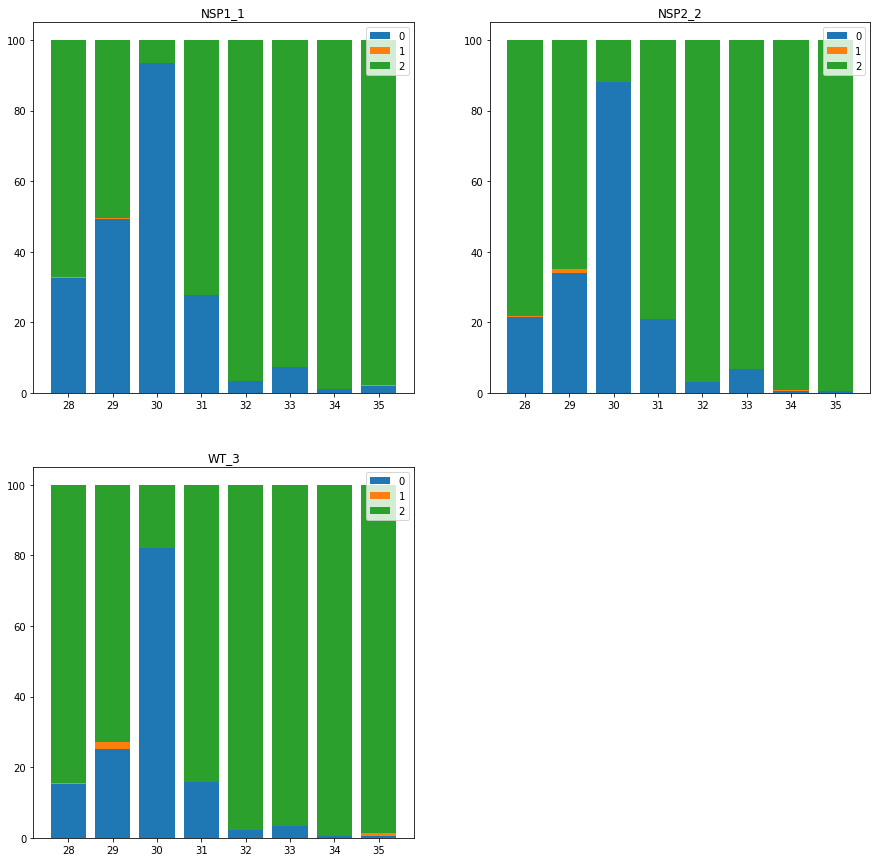

In [39]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 15]

NSP1_1_dominant_positions = \
    arrange_dom_pos_count_percentages(max_position_triplets = max_position_triplet_percentages, 
                                   experiment            = "20200717-NSP1-HEK-1-setB" )

display_html("<center><b>Percentages of Dominant Positions</b></center>", raw = True)
ind = range(len(NSP1_1_dominant_positions[0]))

plt.subplot(2,2,1)

plt.bar(ind, NSP1_1_dominant_positions[0])
plt.bar(ind, NSP1_1_dominant_positions[1], bottom = NSP1_1_dominant_positions[0])
plt.bar(ind, NSP1_1_dominant_positions[2], bottom = np.add(NSP1_1_dominant_positions[0] , NSP1_1_dominant_positions[1]) )

plt.legend((0,1,2))
plt.xticks( ind, range(28,36) );
plt.title("NSP1_1");

NSP2_2_dominant_positions = \
    arrange_dom_pos_count_percentages(max_position_triplets = max_position_triplet_percentages, 
                                   experiment            = "20200717-NSP2-HEK-2-setB" )

ind = range(len(NSP2_2_dominant_positions[0]))

plt.subplot(2,2,2)

plt.bar(ind, NSP2_2_dominant_positions[0])
plt.bar(ind, NSP2_2_dominant_positions[1], bottom = NSP2_2_dominant_positions[0])
plt.bar(ind, NSP2_2_dominant_positions[2], bottom = np.add(NSP2_2_dominant_positions[0] , NSP2_2_dominant_positions[1]) )

plt.legend((0,1,2))
plt.xticks( ind, range(28,36) );
plt.title("NSP2_2");


WT_3_dominant_positions = \
    arrange_dom_pos_count_percentages(max_position_triplets = max_position_triplet_percentages, 
                                   experiment            = "20200717-WT-HEK-3-setB" )

ind = range(len(WT_3_dominant_positions[0]))

plt.subplot(2,2,3)

plt.bar(ind, WT_3_dominant_positions[0])
plt.bar(ind, WT_3_dominant_positions[1], bottom = WT_3_dominant_positions[0])
plt.bar(ind, WT_3_dominant_positions[2], bottom = np.add(WT_3_dominant_positions[0] , WT_3_dominant_positions[1]) )

plt.legend((0,1,2))
plt.xticks( ind, range(28,36) );
plt.title("WT_3");

**Note**: This figure is not for publication. We use it to justify for our choice of the read lengths 31,...35.

The above bar charts demonstrate that the the dominant frame position of the reads, with lengths 31,...,35, is position **2**.   

<a name="read-lengths-at-pause-site"></a>
## Read lengths at the pause site

Here we ask the following.

**Question:** *For the reads at the pause site, what are the lengths of those reads? Are they uniformly distributed or biased towards a particular read lenght(s)?* 



First let's recall that the pause site is b etween positions 262 (inclusive) and 271 (exclusive)

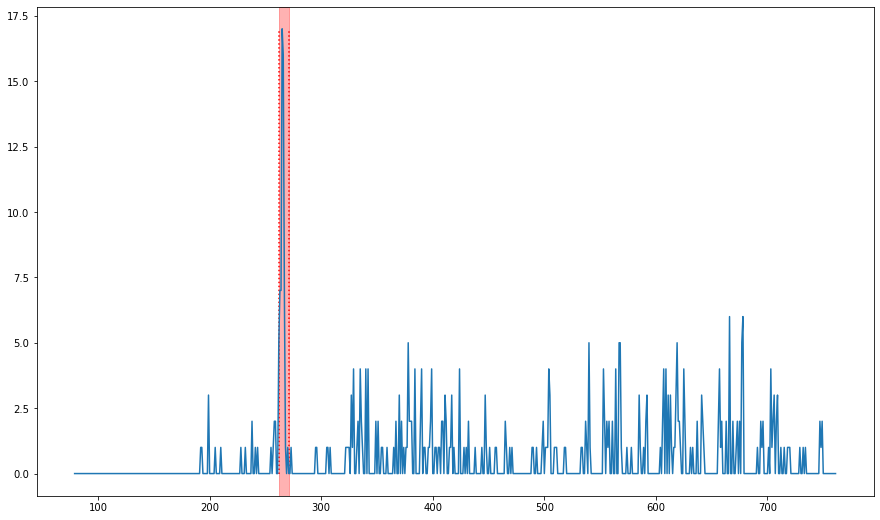

In [40]:
plt.rcParams['figure.figsize'] = [15, 9]

pause_start = 262
pause_stop  = 271
#OAZ1_coverages

cds_start = 79 
cds_stop  = 762

NSP1_1_OAZ1_coverages = np.zeros(762 - 79)

for this_length in range(28, 36):
    NSP1_1_OAZ1_coverages = \
        np.add( NSP1_1_OAZ1_coverages, 
                OAZ1_coverages[this_length]["20200717-NSP1-HEK-1-setB"][cds_start:cds_stop] )
    

plt.plot( tuple(range(cds_start, cds_stop)), NSP1_1_OAZ1_coverages )

plt.vlines((pause_start , pause_stop), ymin = 0, ymax = 17, 
           colors=["red", "red"], linestyles=["dotted", "dotted"]);
plt.axvspan(pause_start , pause_stop, color='red', alpha=0.3);

Not for publication. Now we count the number of reads in this highlighted interval.

In [41]:
pause_site_read_counts = dict()
pause_site_read_ratios = dict()

for e in EXPERIMENT_SET:
    pause_site_read_counts[e] = dict()
    pause_site_read_ratios[e] = dict()
    
    for this_length in range(28, 36):
        pause_site_read_counts[e][this_length] = np.sum(OAZ1_coverages[this_length][e][pause_start:pause_stop])
        total_counts                           = np.sum(OAZ1_coverages[this_length][e][cds_start:cds_stop])
        pause_site_read_ratios[e][this_length] = pause_site_read_counts[e][this_length] / total_counts

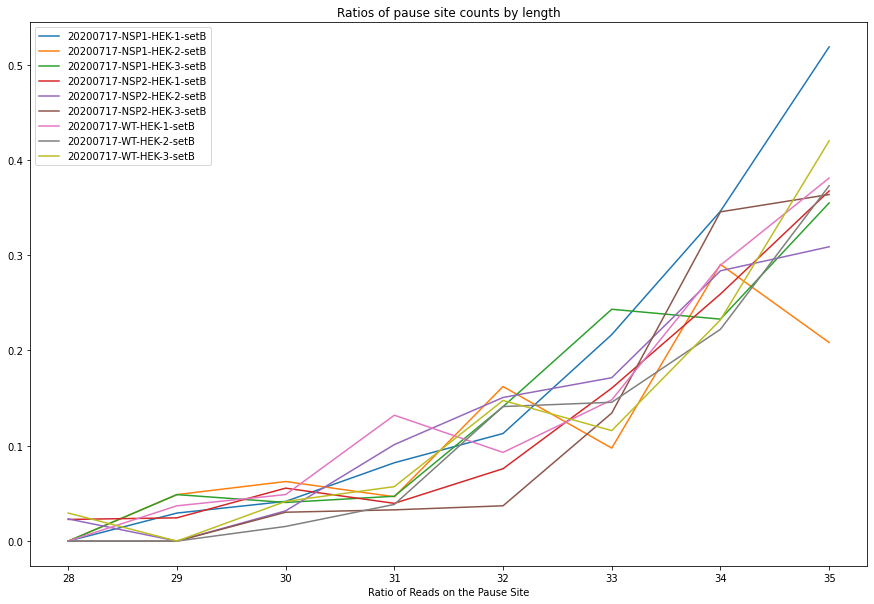

In [42]:
plt.rcParams['figure.figsize'] = [15, 10]
length_range = tuple(range(28, 36))

for e in EXPERIMENT_SET:
    ratios = [ pause_site_read_ratios[e][this_length] for this_length in length_range ]
    plt.plot(length_range,ratios)
    
plt.title("Ratios of pause site counts by length")
plt.xlabel("Read Length")
plt.xlabel("Ratio of Reads on the Pause Site")
plt.legend(EXPERIMENT_SET);

Not for publication.

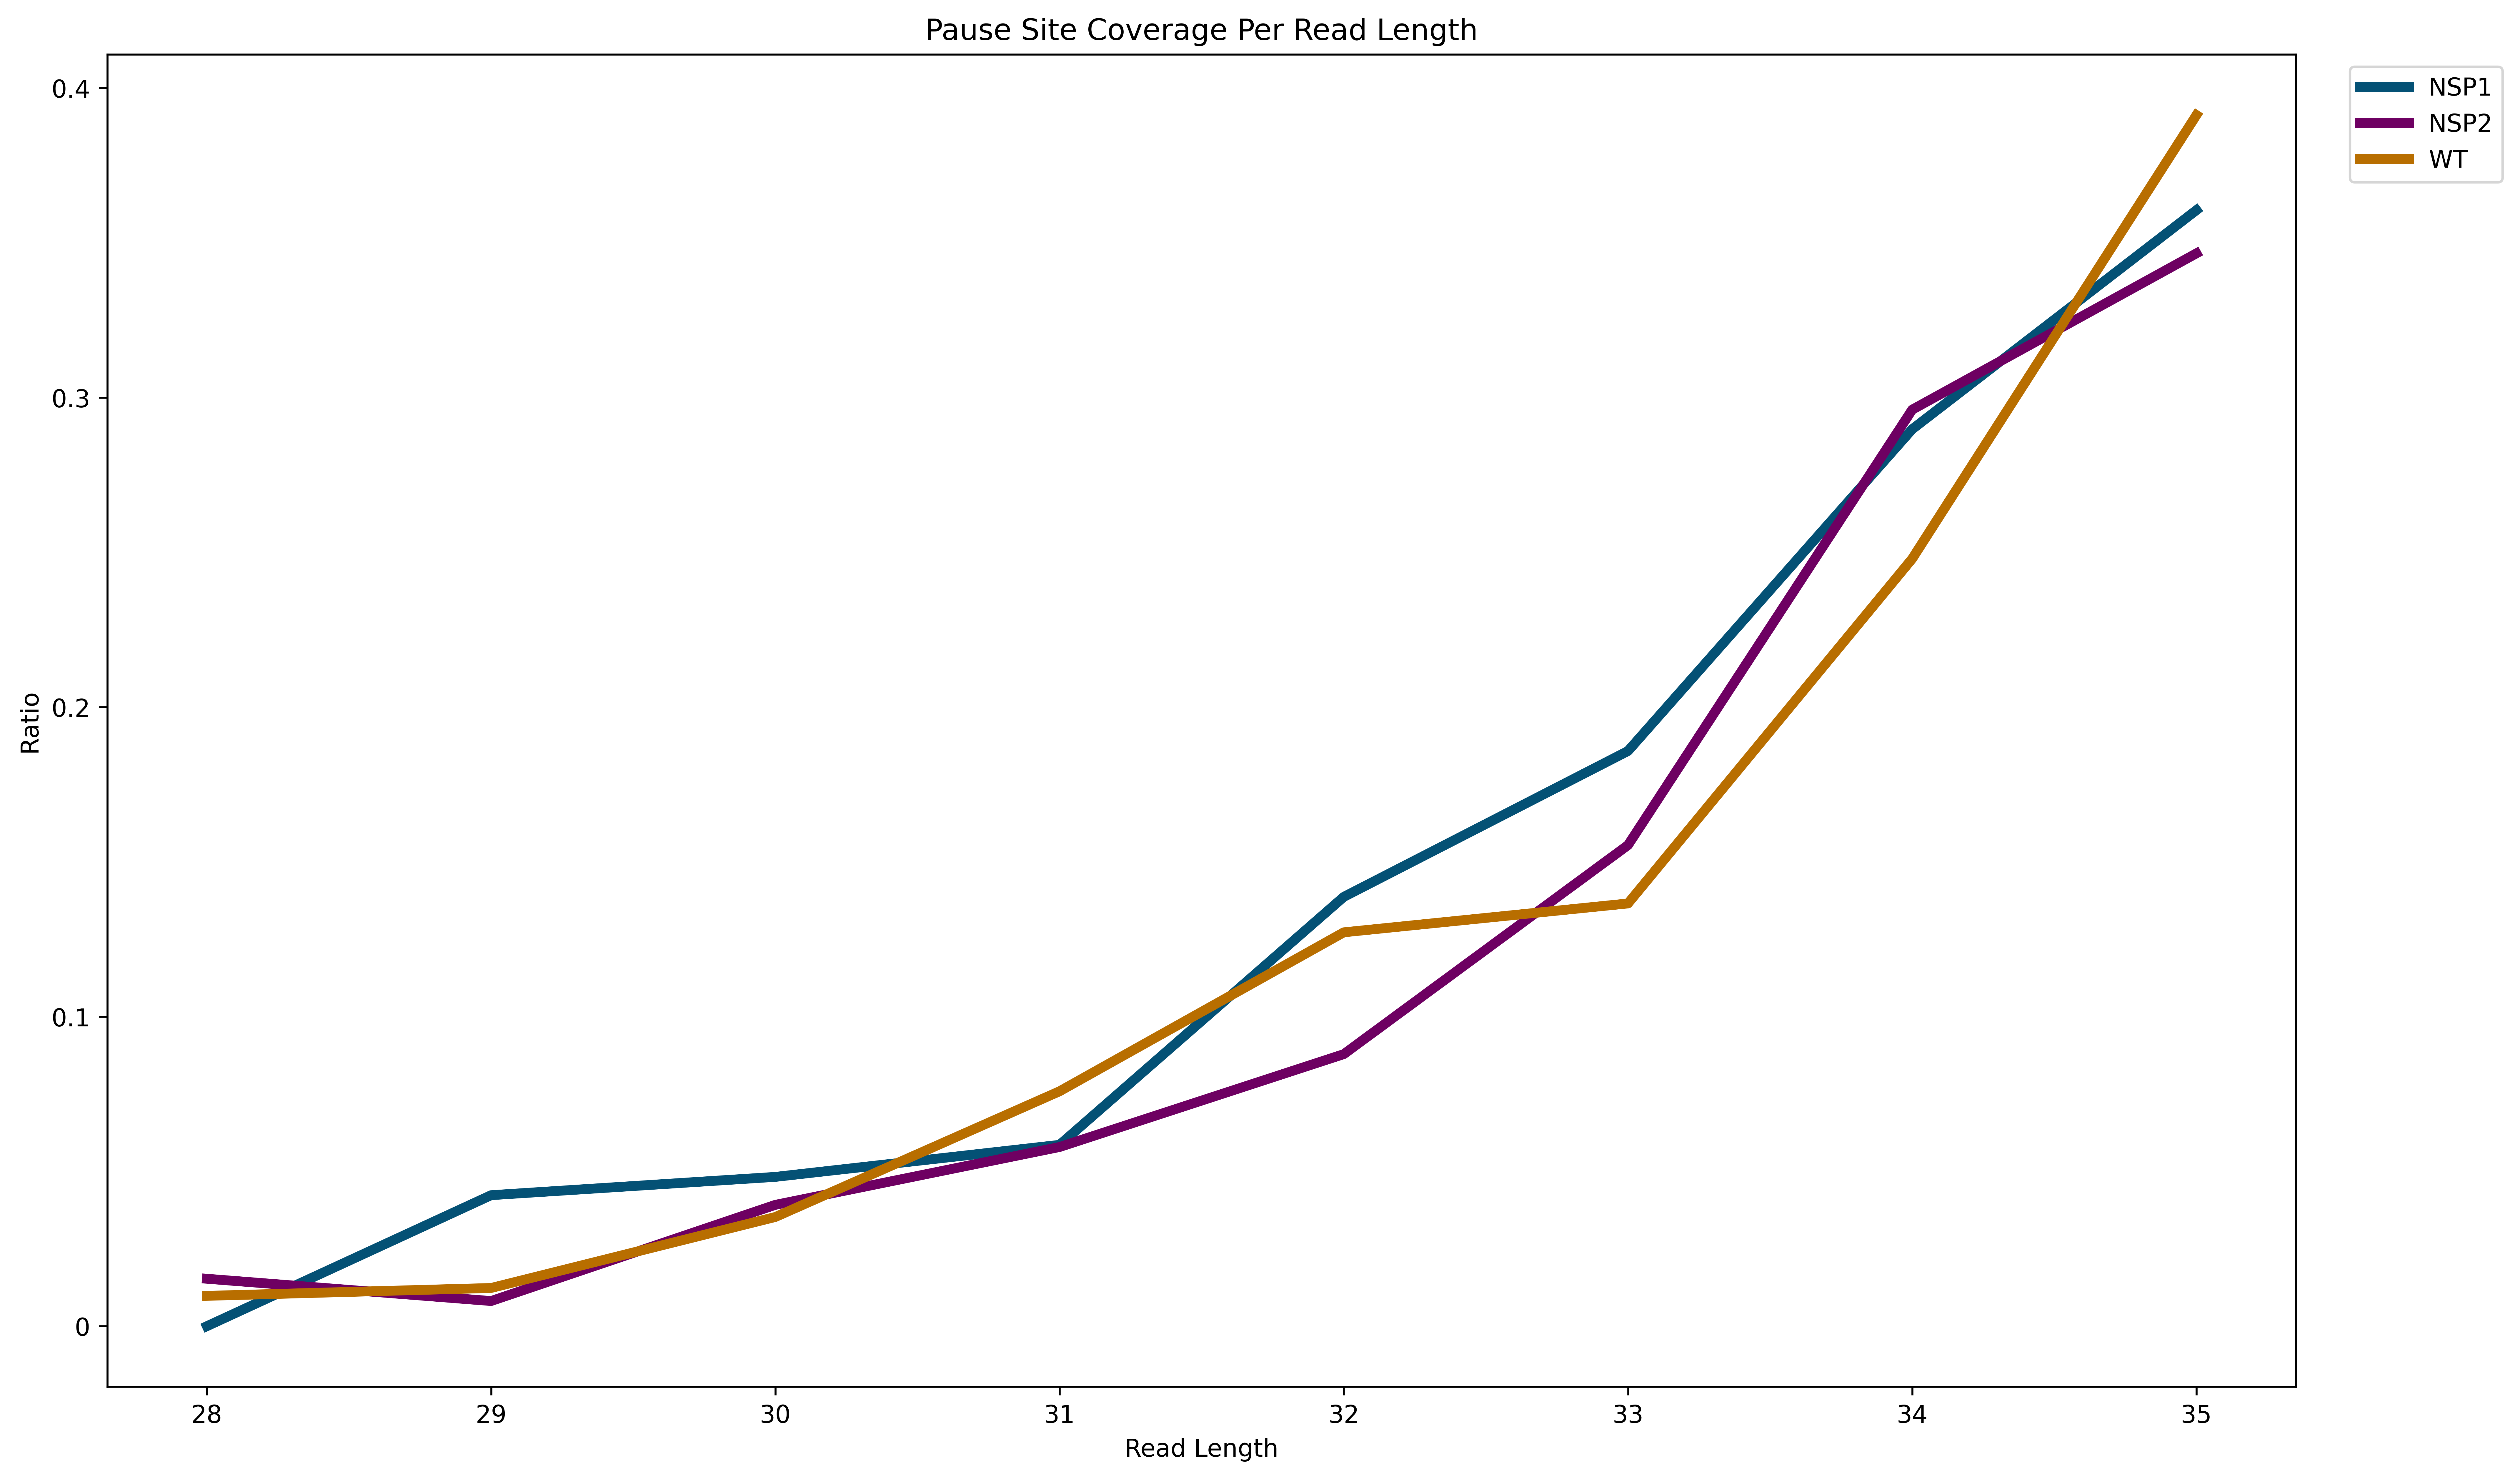

In [43]:
plt.rcParams['figure.figsize'] = [16, 10]

plt.figure( 1, (16,10),dpi = FIGURE_RESOLUTION );

length_range = tuple(range(28, 36))
LINE_WIDTH   = 4



NSP1_1_ratios = [ pause_site_read_ratios["20200717-NSP1-HEK-1-setB"][this_length] for this_length in length_range ]
NSP1_2_ratios = [ pause_site_read_ratios["20200717-NSP1-HEK-2-setB"][this_length] for this_length in length_range ]
NSP1_3_ratios = [ pause_site_read_ratios["20200717-NSP1-HEK-3-setB"][this_length] for this_length in length_range ]

NSP2_1_ratios = [ pause_site_read_ratios["20200717-NSP2-HEK-1-setB"][this_length] for this_length in length_range ]
NSP2_2_ratios = [ pause_site_read_ratios["20200717-NSP2-HEK-2-setB"][this_length] for this_length in length_range ]
NSP2_3_ratios = [ pause_site_read_ratios["20200717-NSP2-HEK-3-setB"][this_length] for this_length in length_range ]


WT_1_ratios = [ pause_site_read_ratios["20200717-WT-HEK-1-setB"][this_length] for this_length in length_range ]
WT_2_ratios = [ pause_site_read_ratios["20200717-WT-HEK-2-setB"][this_length] for this_length in length_range ]
WT_3_ratios = [ pause_site_read_ratios["20200717-WT-HEK-3-setB"][this_length] for this_length in length_range ]


NSP1_average_ratios = np.add(NSP1_3_ratios , np.add(NSP1_1_ratios, NSP1_2_ratios))
NSP1_average_ratios = np.divide(NSP1_average_ratios, 3)

NSP2_average_ratios = np.add(NSP2_3_ratios , np.add(NSP2_1_ratios, NSP2_2_ratios))
NSP2_average_ratios = np.divide(NSP2_average_ratios, 3)

WT_average_ratios = np.add(WT_3_ratios , np.add(WT_1_ratios, WT_2_ratios))
WT_average_ratios = np.divide(WT_average_ratios, 3)

plt.plot( length_range, NSP1_average_ratios, 
          color     = EXPERIMENT_COLORS["20200717-NSP1-HEK-1-setB"],
          linewidth = LINE_WIDTH);

plt.plot( length_range, NSP2_average_ratios, 
          color     = EXPERIMENT_COLORS["20200717-NSP2-HEK-1-setB"],
          linewidth = LINE_WIDTH);

plt.plot( length_range, WT_average_ratios, 
          color     = EXPERIMENT_COLORS["20200717-WT-HEK-1-setB"],
          linewidth = LINE_WIDTH);


plt.legend( ("NSP1", "NSP2", "WT"), 
           loc= "upper right",
           bbox_to_anchor=(1.1, 1))

plt.yticks( (0, 0.1, 0.2, 0.3, 0.4), (0, 0.1, 0.2, 0.3, 0.4) );
plt.title("Pause Site Coverage Per Read Length")
plt.xlabel("Read Length");
plt.ylabel("Ratio");

plt.savefig("pause_site_coverage_per_length.pdf")

**Figure**: Ration of the reads at the pause site for individual read lengths. For each ribosome footprint length from 28 to 35, we counted the number of reads mapping to the pause site (positions from 259 to 271). We divide this number to the total number of reads mapping to OAZ1. We took the average of the ratios for each condition NSP1, NSP2 and WT.

In [44]:
PAUSE_START, PAUSE_STOP

(259, 271)

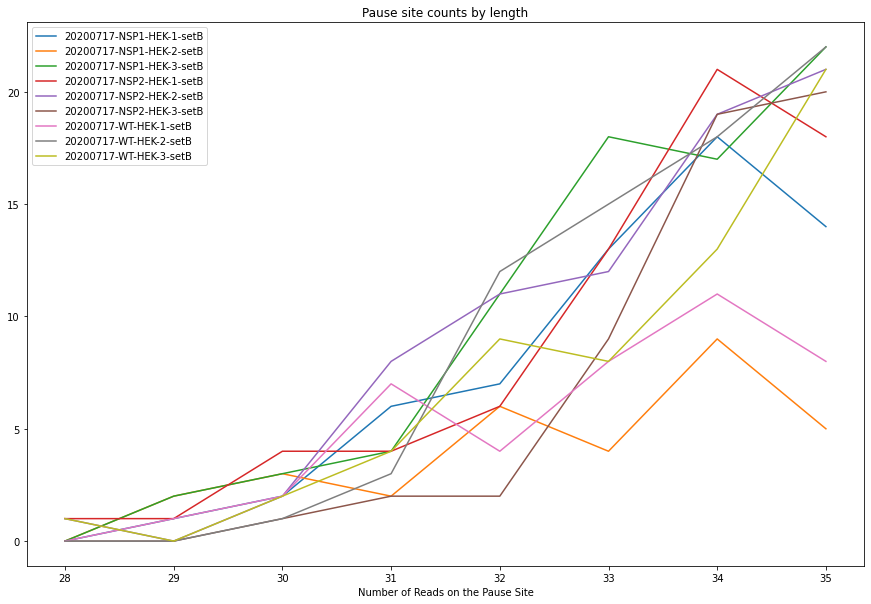

In [45]:
plt.rcParams['figure.figsize'] = [15, 10]
length_range = tuple(range(28, 36))

for e in EXPERIMENT_SET:
    counts = [ pause_site_read_counts[e][this_length] for this_length in length_range ]
    plt.plot(length_range, counts)
    
plt.title("Pause site counts by length")
plt.xlabel("Read Length")
plt.xlabel("Number of Reads on the Pause Site")
plt.legend(EXPERIMENT_SET);

In [46]:
cds_stop

762

In [47]:
plt.rcParams['figure.figsize'] = [15, 30]

this_experiment = "20200717-NSP1-HEK-3-setB"
xrange          = tuple(range(cds_start, cds_stop))

display_html("<center><b>{} Coverage by Read Length</b></center>".format(this_experiment), raw = True)

plt.figure( 1, (15,30),dpi = FIGURE_RESOLUTION );

for i in range(8):
    
    plt.subplot(4,2,1 + i)
    plt.ylim((-0.3, 11))
    
    if i % 2 == 0:
        plt.ylabel("Number of Reads")
        
    if i in [6,7]:
        plt.xlabel("Position")

    plt.plot(xrange, OAZ1_coverages[28 + i][this_experiment][cds_start:cds_stop],
            color = EXPERIMENT_COLORS[this_experiment])
    
    plt.fill_between(x     = (PAUSE_START , PAUSE_STOP), 
                     y1    = -0.3, y2 = 0, 
                     color = "#e31a1d", alpha = 0.8)
    plt.title(str(28 + i))
    
plt.savefig("oaz1_coverege_by_length.pdf")

20200717-NSP1-HEK-3-setB Coverage by Read Length

**Figure**: Coverage of OAZ1 at the read length level. For each read length from 28 to 35, we plot the coverage of the coding sequence of OAZ1, coming from the third replicate of NSP1. The pause site (positions from 259 to 271) is marked in red.

In [48]:
PAUSE_START, PAUSE_STOP

(259, 271)

In [49]:
plt.rcParams['figure.figsize'] = [16, 16]
this_experiment = "20200717-NSP1-HEK-3-setB"

coverage_colors = []

display_html("<center>Pause site is highlighted in red</center>", raw = True)

this_gene = "OAZ1-211"

cds_start   = coverages[NSP1_experiments[0]][0].loc[this_gene, "cds_start"]
cds_stop    = coverages[NSP1_experiments[0]][0].loc[this_gene, "cds_stop"]

xrange          = tuple(range(cds_start, cds_stop))


plt.figure( 1, (16,16),dpi = FIGURE_RESOLUTION )


coverage_set_28_30 = [ OAZ1_coverages[28 + i][this_experiment][cds_start:cds_stop] for i in (0,1,2)  ]
coverage_set_31_33 = [ OAZ1_coverages[31 + i][this_experiment][cds_start:cds_stop] for i in (0,1,2)  ]
coverage_set_34_35 = [ OAZ1_coverages[34 + i][this_experiment][cds_start:cds_stop] for i in (0,1)  ]
 
coverage_28_30 = reduce(np.add, coverage_set_28_30)
coverage_31_33 = reduce(np.add, coverage_set_31_33)
coverage_34_35 = reduce(np.add, coverage_set_34_35)

aggregated_OAZ1_coveages = [coverage_28_30, coverage_31_33, coverage_34_35]
titles                   = ["Lengths 28, 29, 30", "Lengths 31, 32, 33", "Lengths 34, 35"]
coverage_colors          = [COVERAGE_COLORS["28_30"], 
                            COVERAGE_COLORS["31_33"], 
                            COVERAGE_COLORS["34_35"] ] 


for i in range(3):
    
    plt.subplot(3,1,1 + i)
    plt.ylim(bottom = -0.3 , top = 16)

    plt.plot(xrange, aggregated_OAZ1_coveages[i], 
             color = coverage_colors[i])
    #plt.axvspan(cds_start , cds_stop, color='gray', alpha=0.1)
    plt.fill_between(x     = (PAUSE_START , PAUSE_STOP), 
                     y1    = -0.3, y2 = 0, 
                     color = "#e31a1d", alpha = 0.8)
    #plt.axvspan(pause_start , pause_stop, color='red', alpha=0.2);
    plt.ylabel("Number of Mapped Reads")
    plt.xlabel("Nucleotide Position")
    plt.title(titles[i]);
    
plt.savefig("oaz1_coverege_by_interval.pdf")

Pause site is highlighted in red

**Figure**: Coverage of OAZ1 aggregated at increasing read length ranges. 
First we took the read lengths 28, 29 and 30 and summed them up to generate the plot at the top.
We repeated the same process for read lengths 31, 32, 33 and 34, 35 to generate the middle and bottom plots, respectively. 
The pause site (positions from 259 to 271) is marked in red.